## Data and Package Importing

In [2]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80, frameon=False)

### Load data and preprocess

In [3]:
%time s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad')

CPU times: user 3.27 s, sys: 575 ms, total: 3.84 s
Wall time: 3.9 s


In [4]:
s1

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter'

In [5]:
# checkpoint raw data for future filtering
s1.raw = s1

In [6]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 3.05 s, sys: 821 ms, total: 3.87 s
Wall time: 3.87 s


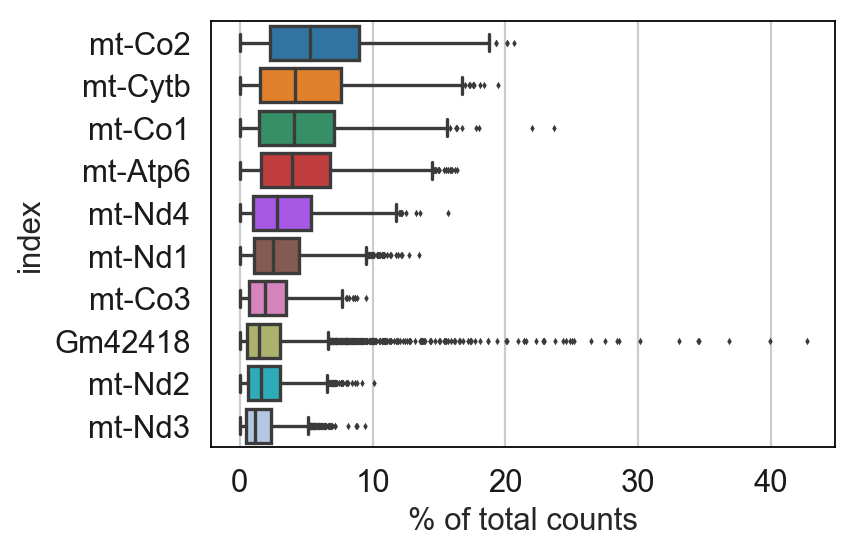

In [7]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

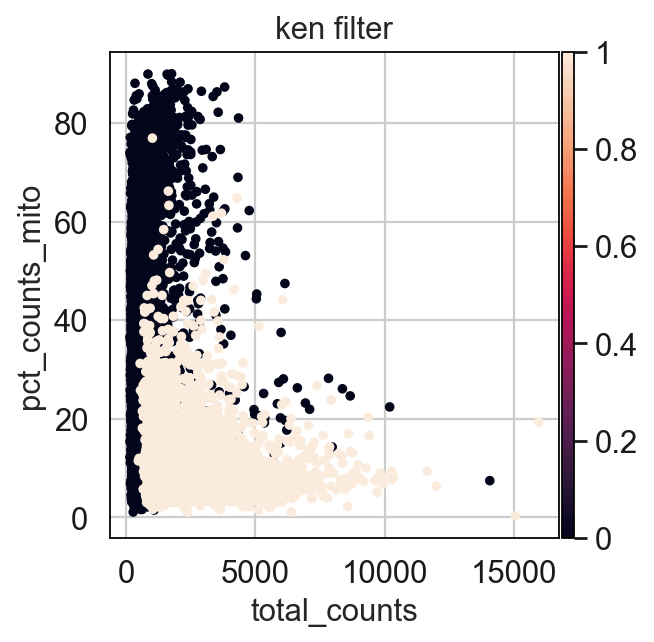

In [8]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Find inflection point

Inflection point at index
bcFJXN    2529
bcFXFE    3401
bcBMLL    1176
bcFPYH     676
bcFOEH    6106
bcCZCI     274
bcGBVR    7373
bcEBWV    8063
Name: total_counts, dtype: int64 for [0, 20, 40, 60, 70, 80, 90, 100] percentiles of greatest secant distances


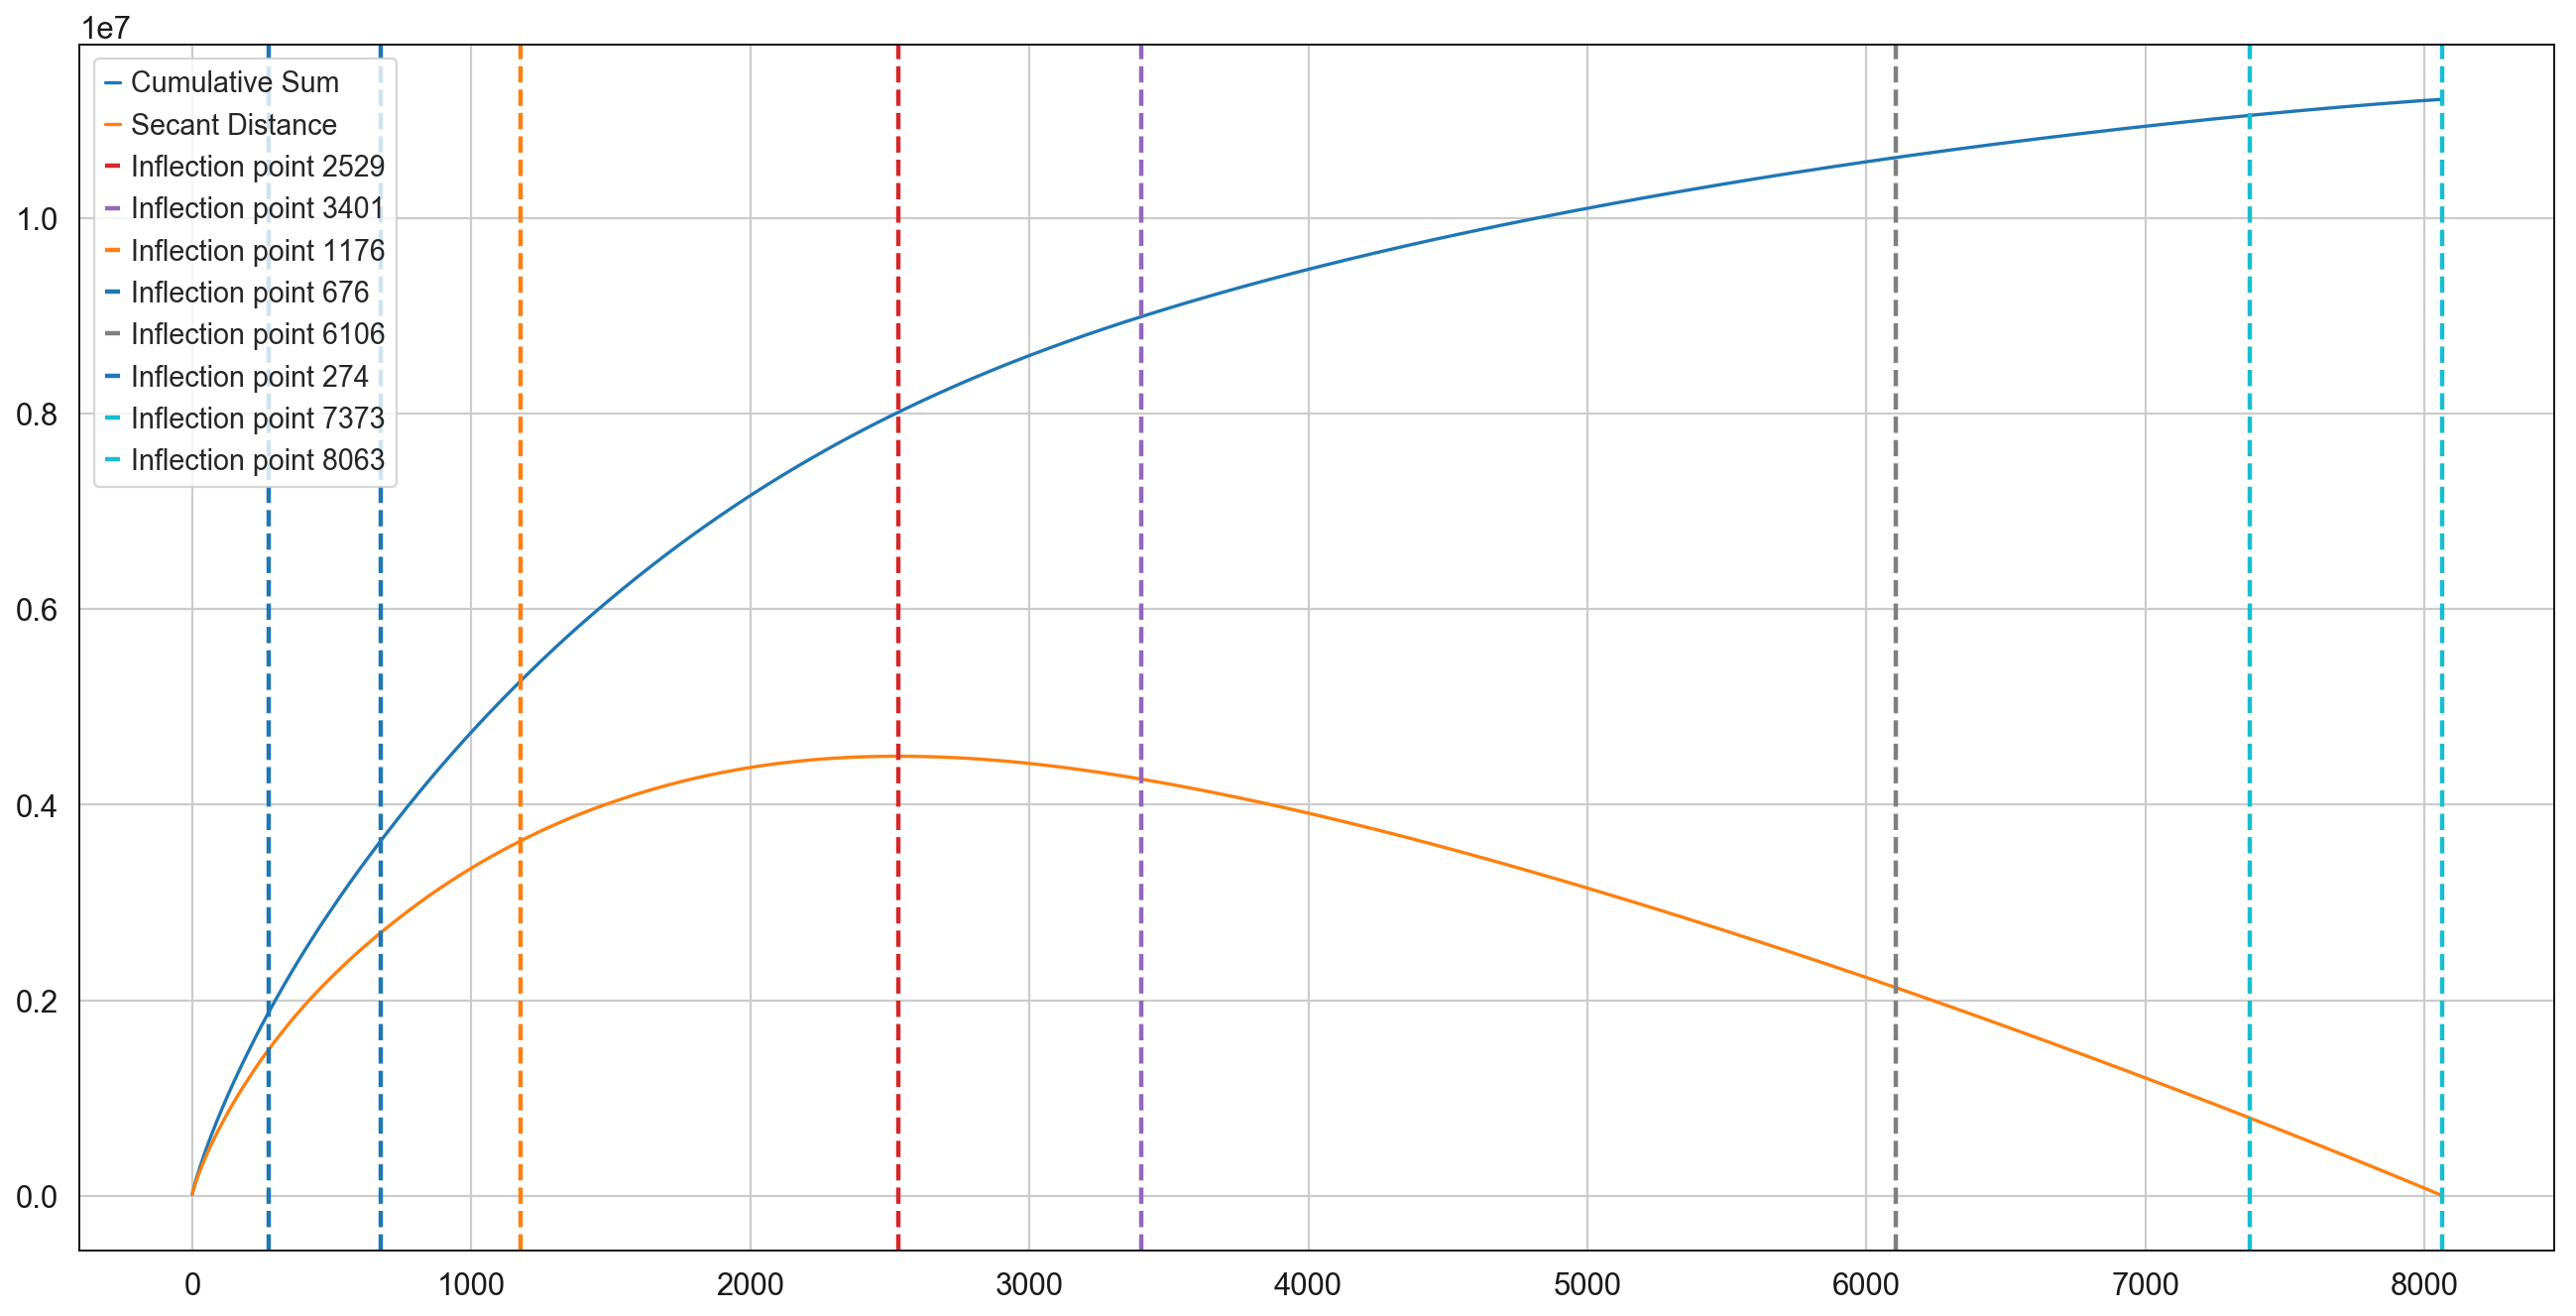

In [9]:
find_inflection(s1, inflection_percentiles = [0,20,40,60,70,80,90,100])

In [10]:
s1.obs['total_counts'][7373] # see the total counts for the cutoff point

278.0

In [18]:
# create new "observation" as empty droplet label
s1.obs['twostep_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][7373], 1, -1) # 1 is empty, -1 is unlabeled
s1.obs.loc[s1.obs['ranked_total_counts']>=s1.n_obs*0.97, 'twostep_empty'] = 0 # take top 3% of dataset by total UMI counts and add as "not empty"

In [19]:
s1.obs['twostep_empty'].value_counts()

-1    7128
 1     695
 0     241
Name: twostep_empty, dtype: int64

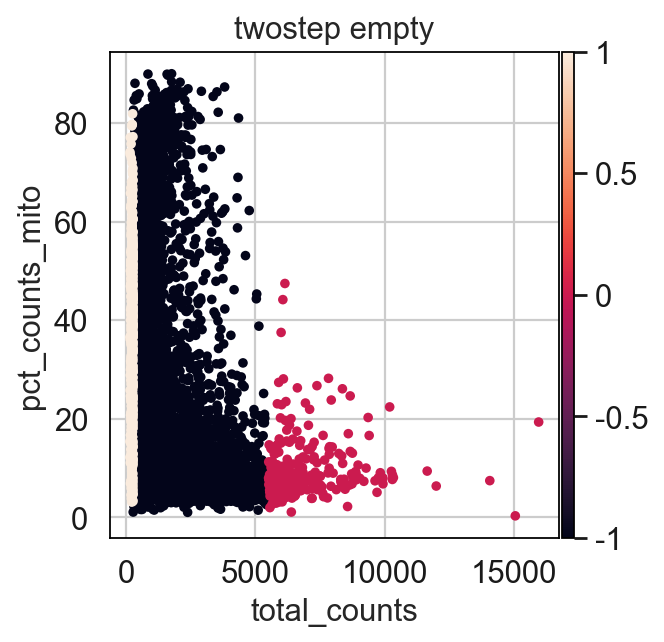

In [20]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_empty', size=75)

### Normalize and perform linear dimensionality reduction with PCA

In [14]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 1.87 s, sys: 259 ms, total: 2.13 s
Wall time: 2.13 s


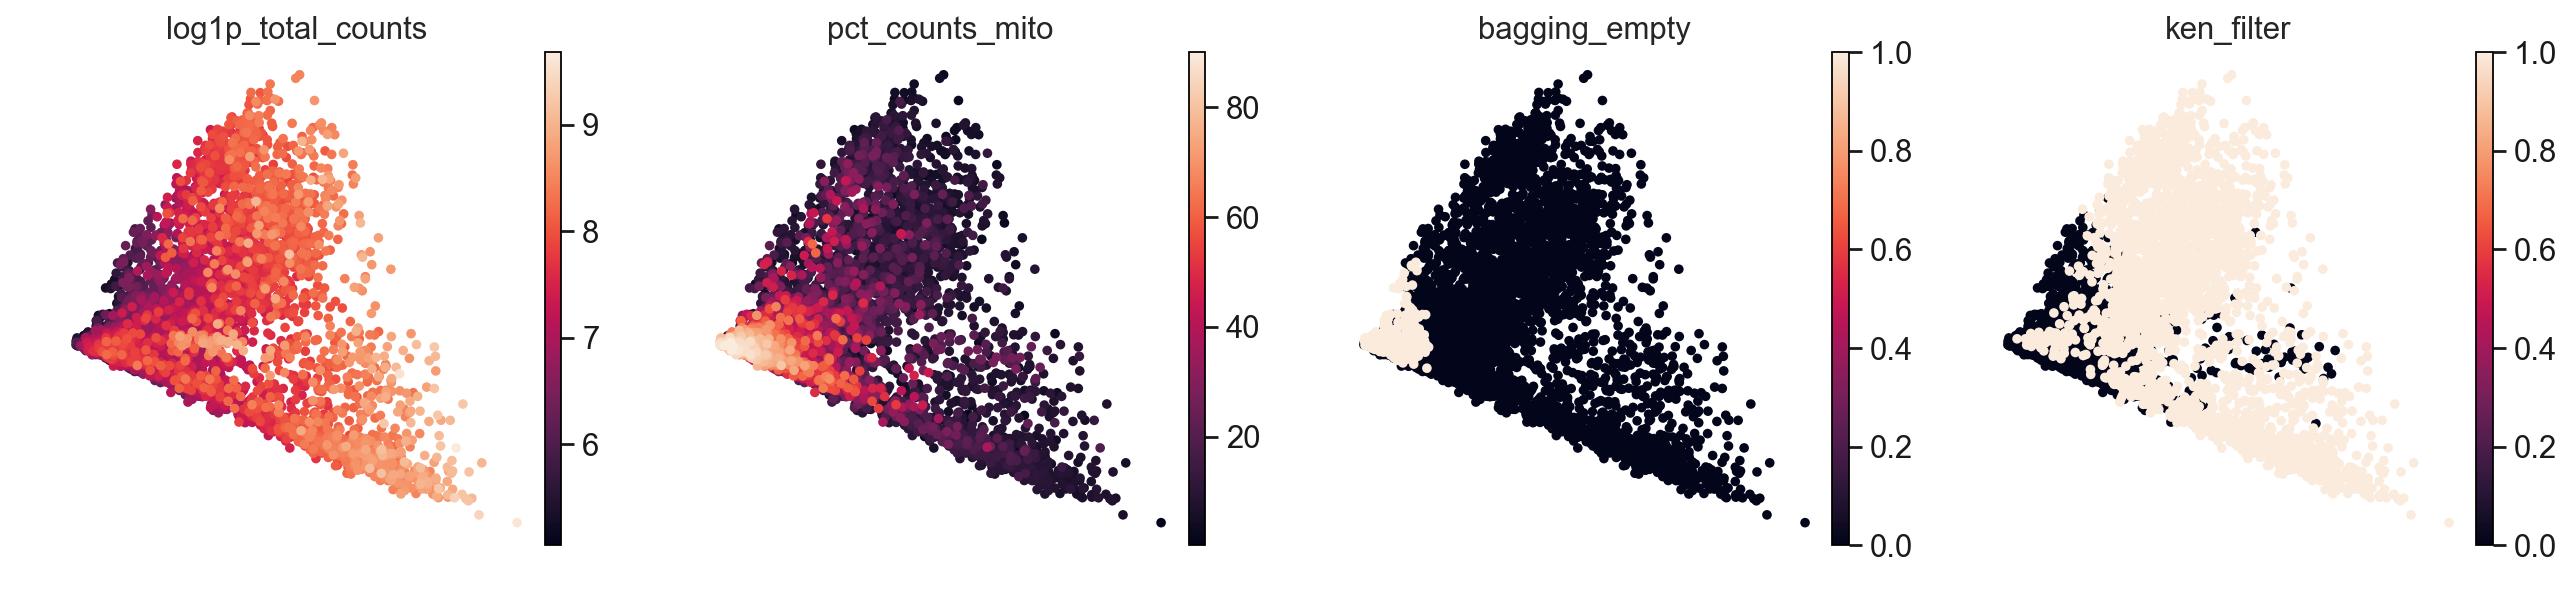

CPU times: user 49.8 s, sys: 3.19 s, total: 53 s
Wall time: 9.78 s


In [15]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','bagging_empty','ken_filter'], ncols=4, size=75)

---
### TwoStep

In [21]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [22]:
%%time
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier, you can plug in any classifier though!
scores_twostep_empty, labels_twostep_empty = twoStep(clf=rf, X=X, y=y, n_iter=18)

Step 1 labeled 1301 new positives and 57 new negatives.
Iteration 1: Doing step 2... Step 1 labeled 250 new positives and 41 new negatives.
Iteration 2: Doing step 2... Step 1 labeled 65 new positives and 29 new negatives.
Iteration 3: Doing step 2... Step 1 labeled 64 new positives and 15 new negatives.
Iteration 4: Doing step 2... Step 1 labeled 28 new positives and 9 new negatives.
Iteration 5: Doing step 2... Step 1 labeled 33 new positives and 10 new negatives.
Iteration 6: Doing step 2... Step 1 labeled 24 new positives and 7 new negatives.
Iteration 7: Doing step 2... Step 1 labeled 23 new positives and 15 new negatives.
Iteration 8: Doing step 2... Step 1 labeled 13 new positives and 19 new negatives.
Iteration 9: Doing step 2... Step 1 labeled 15 new positives and 14 new negatives.
Iteration 10: Doing step 2... Step 1 labeled 6 new positives and 15 new negatives.
Iteration 11: Doing step 2... Step 1 labeled 11 new positives and 19 new negatives.
Iteration 12: Doing step 2... S

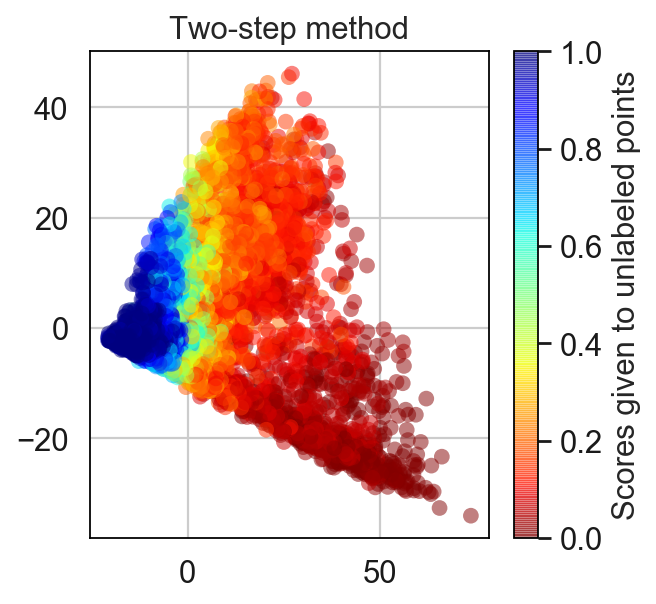

In [23]:
# visualize final TwoStep results
plt.scatter(
    X[:,0], X[:,1], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

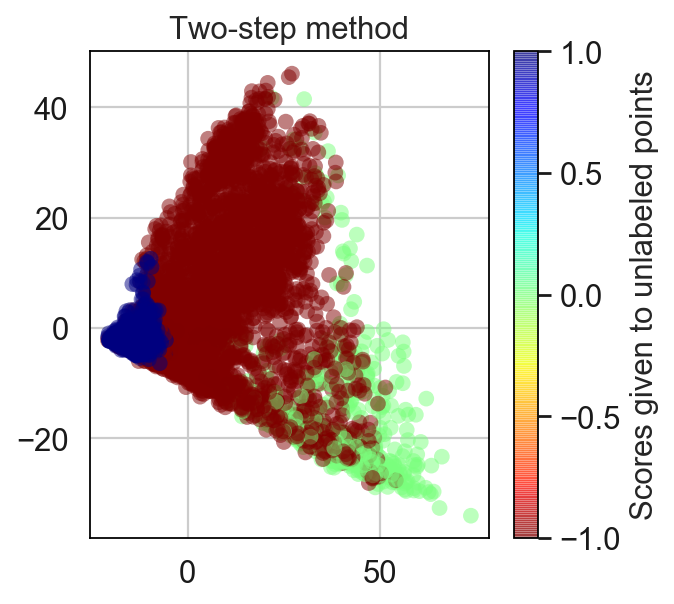

In [24]:
# visualize final TwoStep results
plt.scatter(
    X[:,0], X[:,1], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

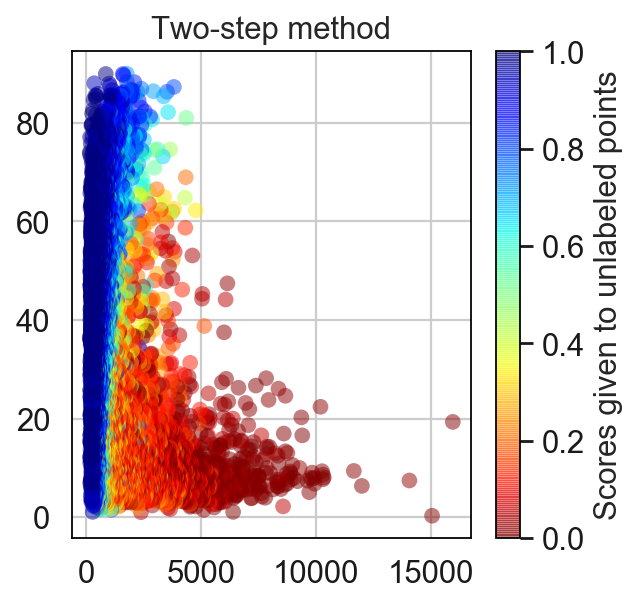

In [25]:
# visualize final TwoStep results
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

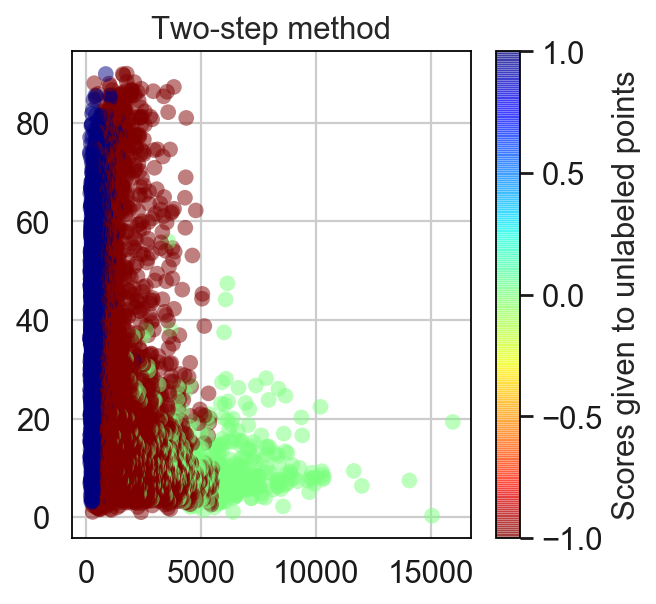

In [26]:
# visualize final TwoStep results
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

In [27]:
s1.obs['twostep_result'] = np.where(scores_twostep_empty>=0.5, 1, 0)

In [28]:
s1.obs['ken_filter'].value_counts()

0    5349
1    2715
Name: ken_filter, dtype: int64

In [29]:
s1.obs['twostep_result'].value_counts()

1    4926
0    3138
Name: twostep_result, dtype: int64

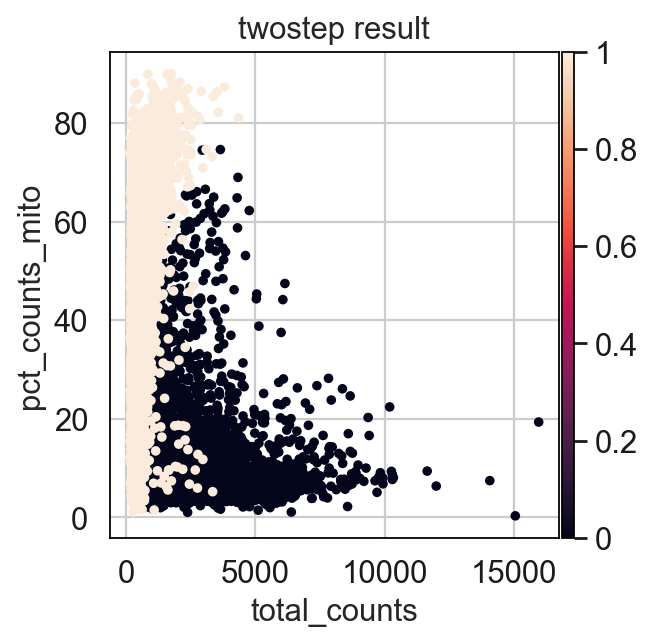

In [30]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_result', size=75)

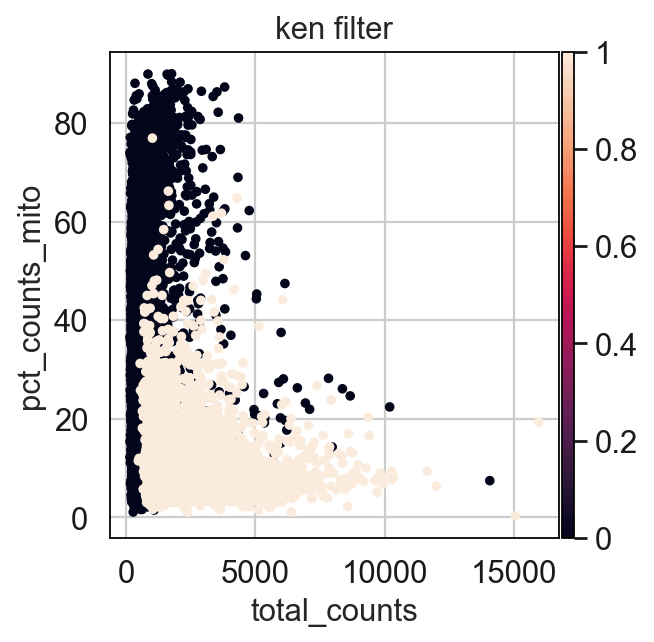

In [31]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [32]:
s1_notempty = s1[s1.obs['twostep_result']==0,:].copy() # move forward with non-empty droplets

In [33]:
s1_notempty.X = s1_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [34]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 745 ms, sys: 42.9 ms, total: 788 ms
Wall time: 788 ms


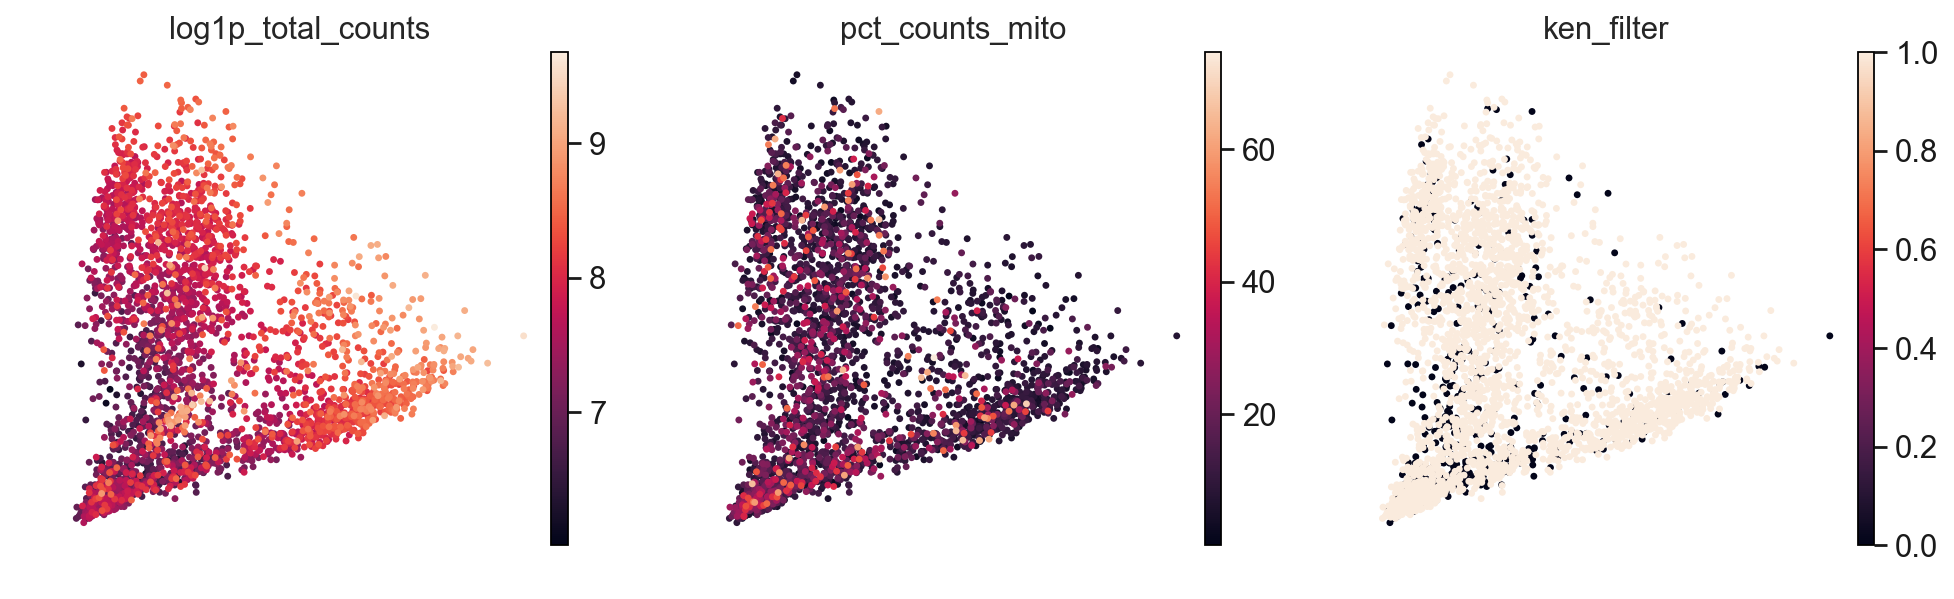

CPU times: user 25.2 s, sys: 2.22 s, total: 27.5 s
Wall time: 4.28 s


In [35]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

### Clustering

In [39]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_notempty, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

CPU times: user 1.15 s, sys: 109 ms, total: 1.26 s
Wall time: 631 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


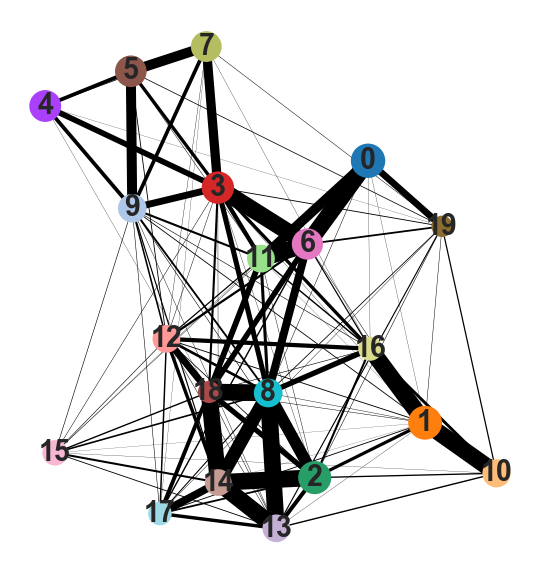

In [40]:
sc.tl.paga(s1_notempty) #perform PAGA
sc.pl.paga(s1_notempty)

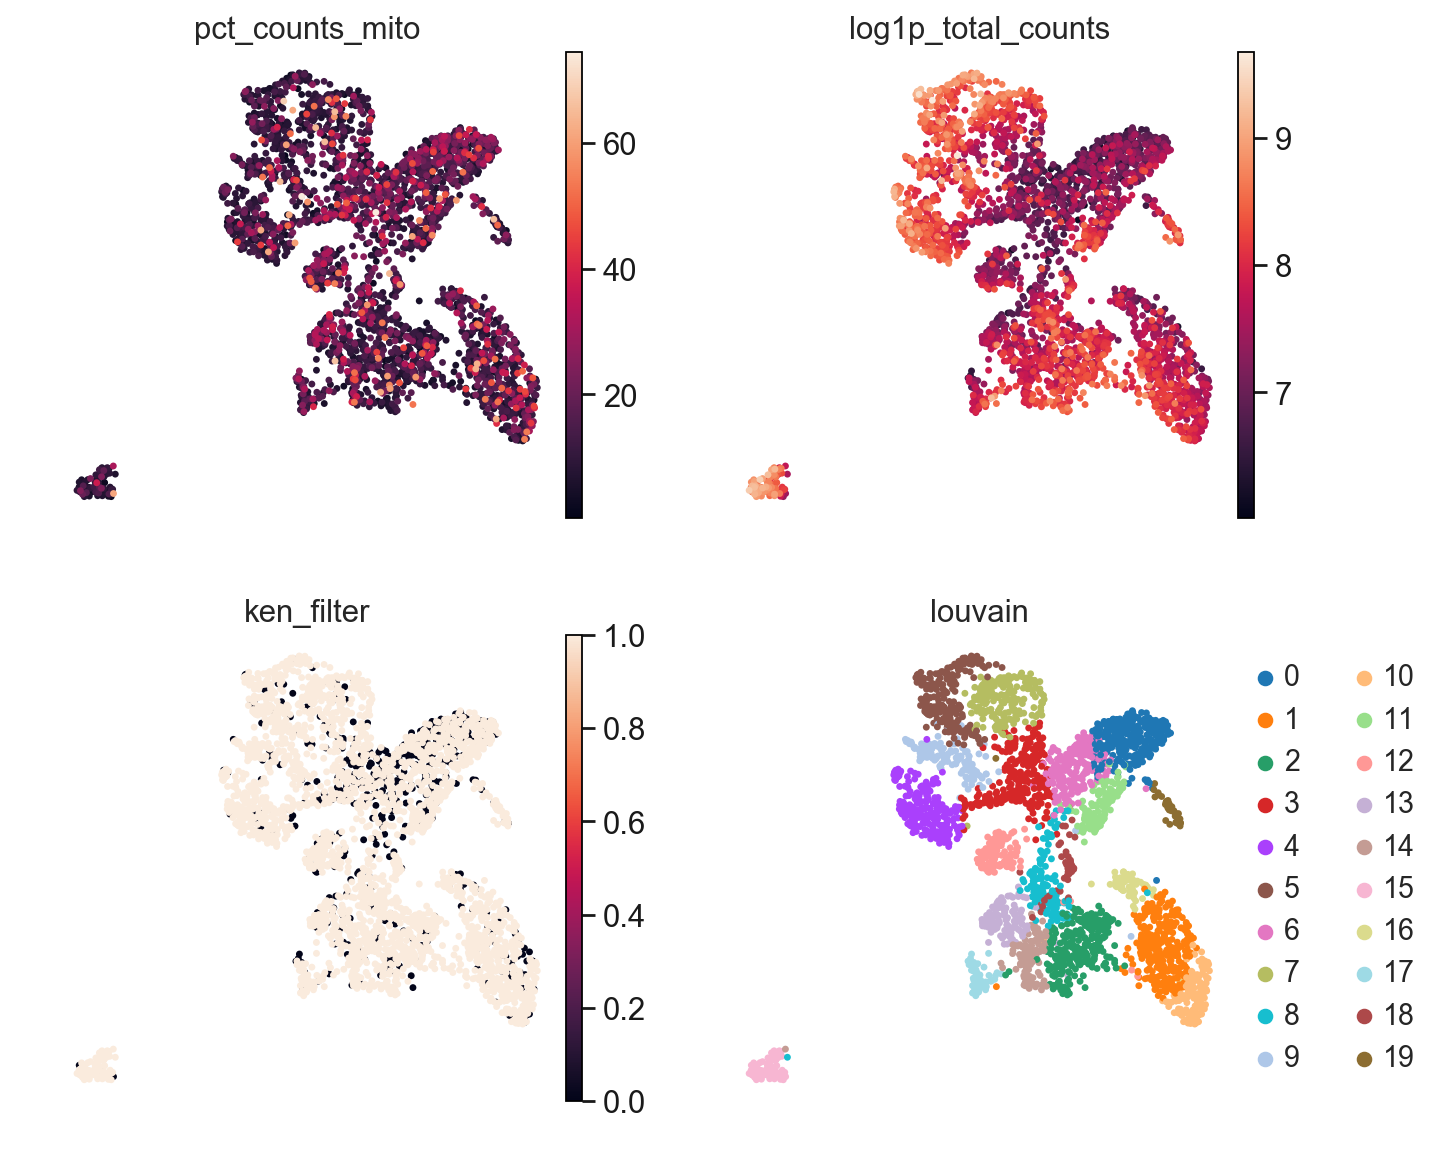

In [41]:
sc.tl.umap(s1_notempty, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_notempty))
sc.pl.umap(s1_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter','louvain'], ncols=2)

---
## Ken Filtering

In [42]:
s1_gold = s1[s1.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets

In [43]:
s1_gold.X = s1_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [44]:
%%time
sc.pp.normalize_total(s1_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_gold) # log1p transformation
sc.pp.scale(s1_gold, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 632 ms, sys: 22.2 ms, total: 654 ms
Wall time: 654 ms


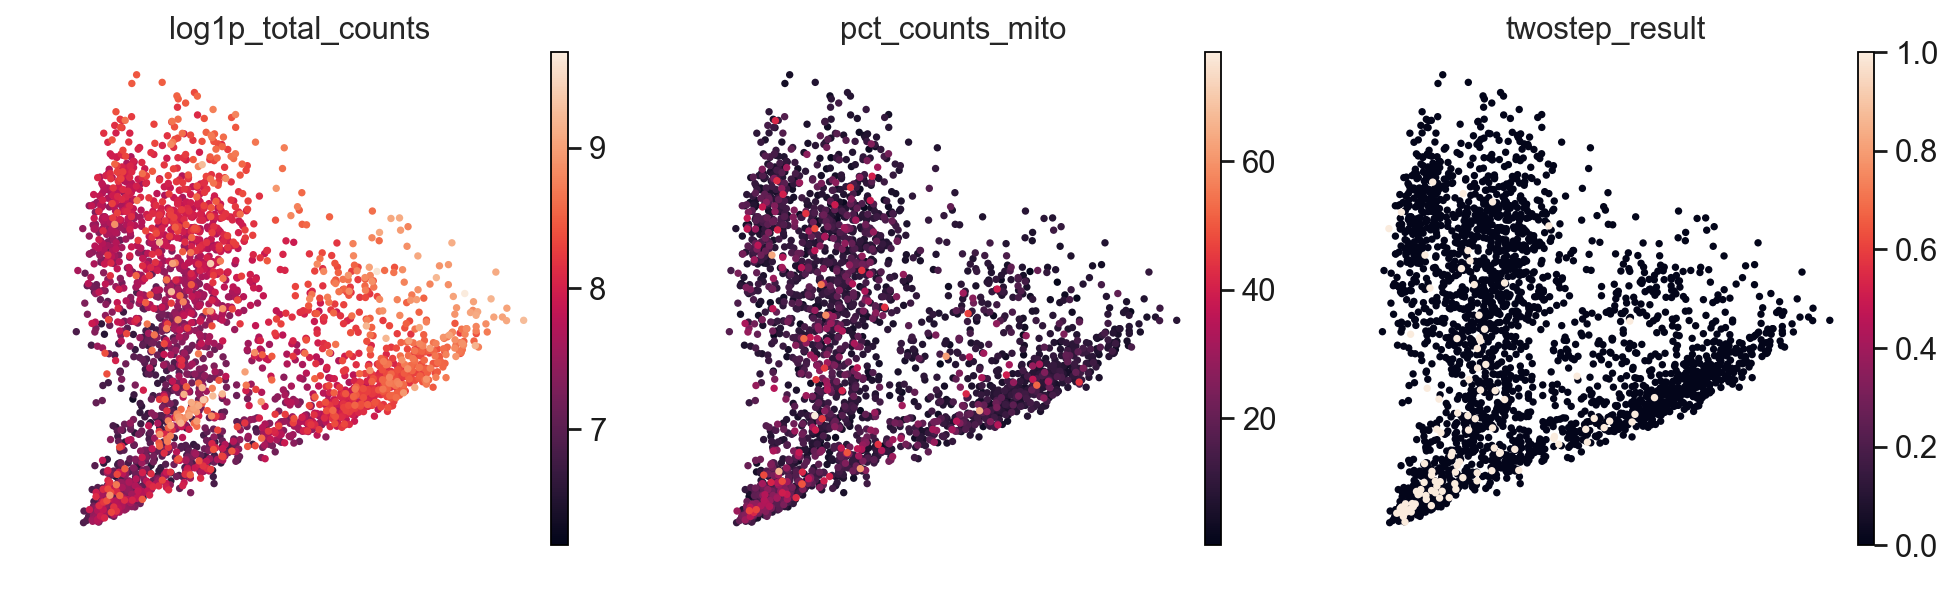

CPU times: user 23 s, sys: 2.35 s, total: 25.4 s
Wall time: 3.81 s


In [46]:
%%time
sc.tl.pca(s1_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_gold, color=['log1p_total_counts','pct_counts_mito','twostep_result'], ncols=3)

### Clustering

In [47]:
%%time
sc.pp.neighbors(s1_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_gold, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

CPU times: user 999 ms, sys: 129 ms, total: 1.13 s
Wall time: 545 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


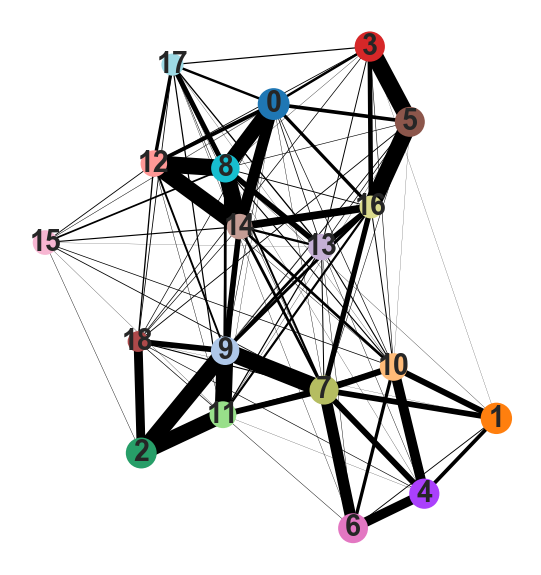

In [48]:
sc.tl.paga(s1_gold) #perform PAGA
sc.pl.paga(s1_gold)

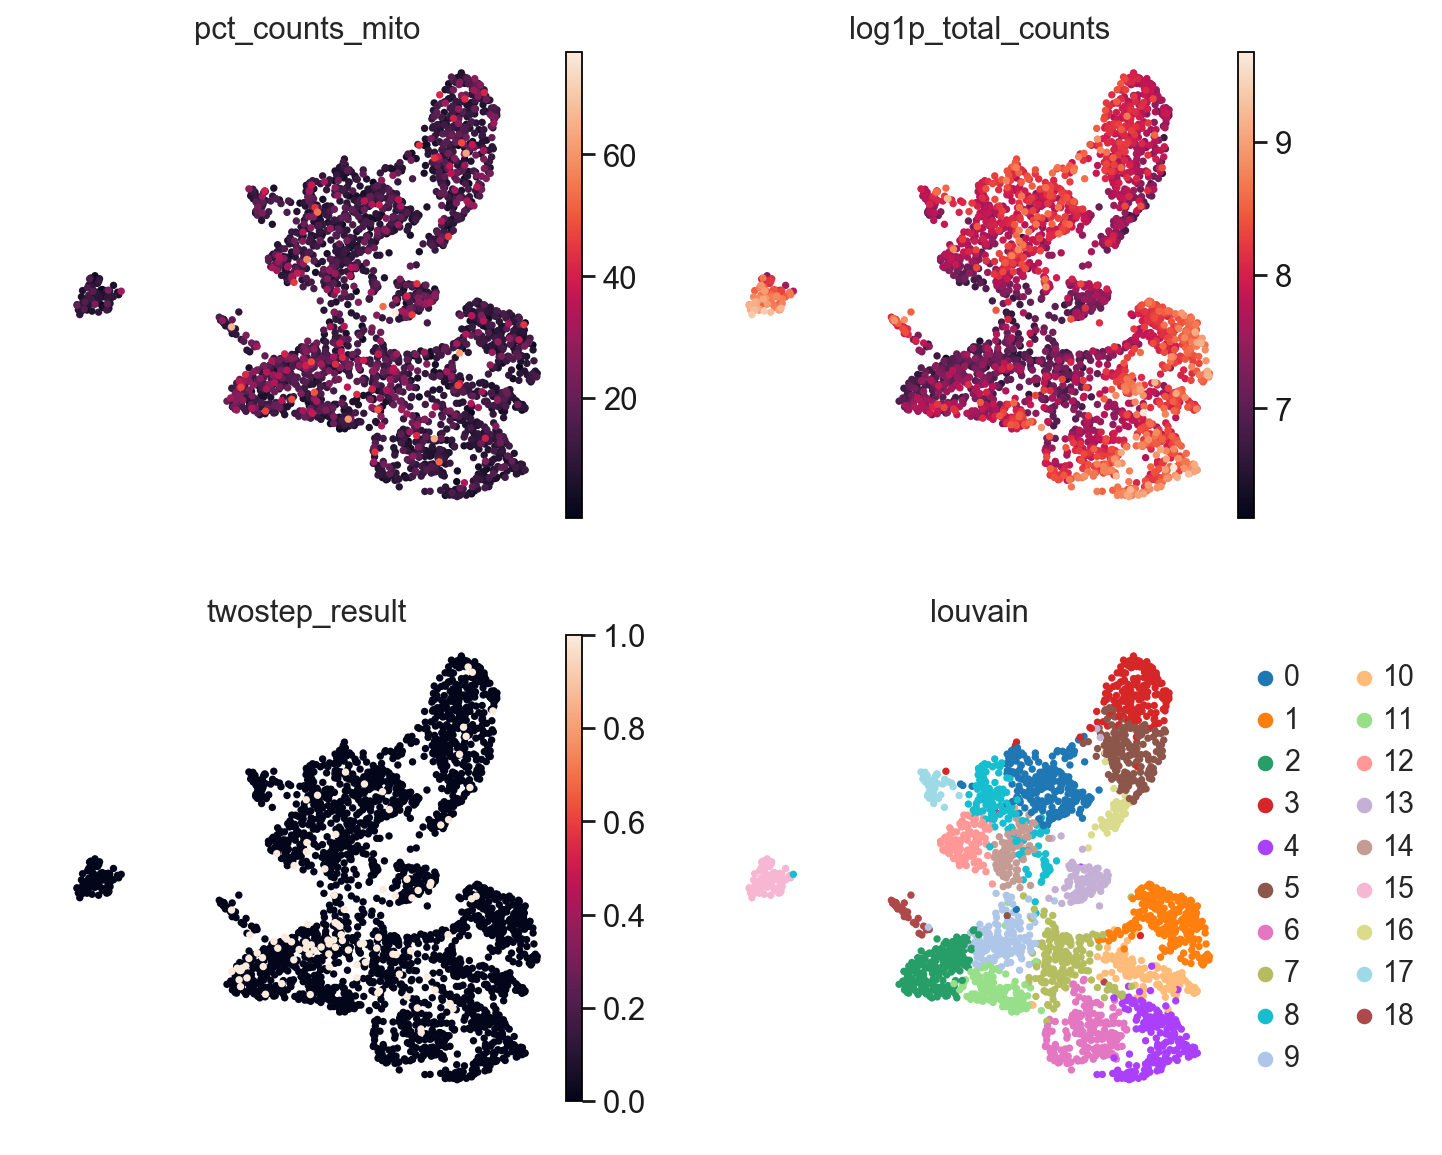

In [49]:
sc.tl.umap(s1_gold, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_gold))
sc.pl.umap(s1_gold, color=['pct_counts_mito','log1p_total_counts','twostep_result','louvain'], ncols=2)